## Question 8

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import time

In [73]:
def rouwen(rho, mu, step, num):
    '''
    Adapted from Lu Zhang and Karen Kopecky. Python by Ben Tengelsen.
    Construct transition probability matrix for discretizing an AR(1)
    process. This procedure is from Rouwenhorst (1995), which works
    well for very persistent processes.

    INPUTS:
    rho  - persistence (close to one)
    mu   - mean and the middle point of the discrete state space
    step - step size of the even-spaced grid
    num  - number of grid points on the discretized process

    OUTPUT:
    dscSp  - discrete state space (num by 1 vector)
    transP - transition probability matrix over the grid
    '''

    # discrete state space
    dscSp = np.linspace(mu -(num-1)/2*step, mu +(num-1)/2*step, num).T

    # transition probability matrix
    q = p = (rho + 1)/2.
    transP = np.array([[p**2, p*(1-q), (1-q)**2], \
                    [2*p*(1-p), p*q+(1-p)*(1-q), 2*q*(1-q)], \
                    [(1-p)**2, (1-p)*q, q**2]]).T


    while transP.shape[0] <= num - 1:

        # see Rouwenhorst 1995
        len_P = transP.shape[0]
        transP = p * np.vstack((np.hstack((transP, np.zeros((len_P, 1)))), np.zeros((1, len_P+1)))) \
                + (1 - p) * np.vstack((np.hstack((np.zeros((len_P, 1)), transP)), np.zeros((1, len_P+1)))) \
                + (1 - q) * np.vstack((np.zeros((1, len_P+1)), np.hstack((transP, np.zeros((len_P, 1)))))) \
                + q * np.vstack((np.zeros((1, len_P+1)), np.hstack((np.zeros((len_P, 1)), transP))))

        transP[1:-1] /= 2.


    # ensure columns sum to 1
    if np.max(np.abs(np.sum(transP, axis=1) - np.ones(transP.shape))) >= 1e-12:
        print('Problem in rouwen routine!')
        return None
    else:
        return transP.T, dscSp

In [74]:
# parameters:
alpha = 0.35
beta = 0.98
rho = 0.9
sigma = 0.02
mu = 0
kbar = (alpha * beta) ** (1 / (1 - alpha))

# z-grid:
size_z = 25
z_step = (10*sigma) / (size_z - 1)
pi, z = rouwen(rho, mu, z_step, 25)



kvec = np.linspace(0.5*kbar, 1.5*kbar, 25)
H = np.zeros((25, 25))
print(kvec)

[ 0.09639131  0.10442392  0.11245653  0.12048914  0.12852175  0.13655436
  0.14458696  0.15261957  0.16065218  0.16868479  0.1767174   0.18475001
  0.19278262  0.20081523  0.20884784  0.21688045  0.22491306  0.23294567
  0.24097827  0.24901088  0.25704349  0.2650761   0.27310871  0.28114132
  0.28917393]


In [75]:
e = np.zeros((25, 25, 25))
for i in range(25): # loop over z
    for j in range(25): # loop over k
        for k in range(25): # loop over k'
            e[i, j, k] = np.log(np.exp(z[i]) * (kvec[j]**alpha) - kvec[k])

print(e[:,0,0])

[-1.19528162 -1.18430844 -1.17336403 -1.162448   -1.15155998 -1.14069958
 -1.12986645 -1.11906022 -1.10828054 -1.09752705 -1.08679942 -1.07609731
 -1.06542038 -1.05476831 -1.04414078 -1.03353748 -1.0229581  -1.01240232
 -1.00186985 -0.9913604  -0.98087368 -0.97040939 -0.95996727 -0.94954702
 -0.93914839]


In [76]:
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros((25, 25))  # initial guess at value function
Vmat = np.zeros((25, 25, 25))  # initialize Vmat matrix
#Vstore = np.zeros((25, VFmaxiter))  # initialize Vstore array
VFiter = 1
start_time = time.clock()

In [77]:
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = np.copy(V)
    V = pi.T @ V
    for i in range(25): # loop over z
        for j in range(25):  # loop over k
            for k in range(25):  # loop over k'
                Vmat[i, j, k] = e[i, j, k] + (beta * V[i, k])
                
    V = Vmat.max(axis=2)  # apply max operator to Vmat (to get V(k))
    H = np.argmax(Vmat, axis=2)  # find the index of the optimal k'
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1


if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
    
VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')    

VF = V  # solution to the functional equation

Value function converged after this many iterations: 686
Value function converged after this many iterations: 686
VFI took  7.597074000000006  seconds to solve


In [78]:
print(H)

[[ 5  6  6  6  7  7  8  8  8  9  9  9 10 10 10 11 11 11 12 12 12 12 13 13
  13]
 [ 5  6  6  7  7  7  8  8  9  9  9 10 10 10 11 11 11 11 12 12 12 12 13 13
  13]
 [ 5  6  6  7  7  8  8  8  9  9  9 10 10 10 11 11 11 12 12 12 12 13 13 13
  14]
 [ 5  6  6  7  7  8  8  8  9  9 10 10 10 11 11 11 11 12 12 12 13 13 13 13
  14]
 [ 6  6  7  7  7  8  8  9  9 10 10 10 10 11 11 11 12 12 12 13 13 13 13 14
  14]
 [ 6  6  7  7  8  8  8  9  9 10 10 10 11 11 11 12 12 12 13 13 13 13 14 14
  14]
 [ 6  6  7  7  8  8  9  9  9 10 10 10 11 11 12 12 12 12 13 13 13 14 14 14
  14]
 [ 6  7  7  8  8  8  9  9 10 10 10 11 11 11 12 12 12 13 13 13 13 14 14 14
  15]
 [ 6  7  7  8  8  9  9  9 10 10 11 11 11 12 12 12 12 13 13 13 14 14 14 14
  15]
 [ 6  7  7  8  8  9  9 10 10 10 11 11 11 12 12 12 13 13 13 14 14 14 14 15
  15]
 [ 7  7  8  8  8  9  9 10 10 11 11 11 12 12 12 13 13 13 13 14 14 14 15 15
  15]
 [ 7  7  8  8  9  9 10 10 10 11 11 12 12 12 12 13 13 13 14 14 14 15 15 15
  15]
 [ 7  7  8  8  9  9 10 10 11 11 11 12 12

<IPython.core.display.Javascript object>


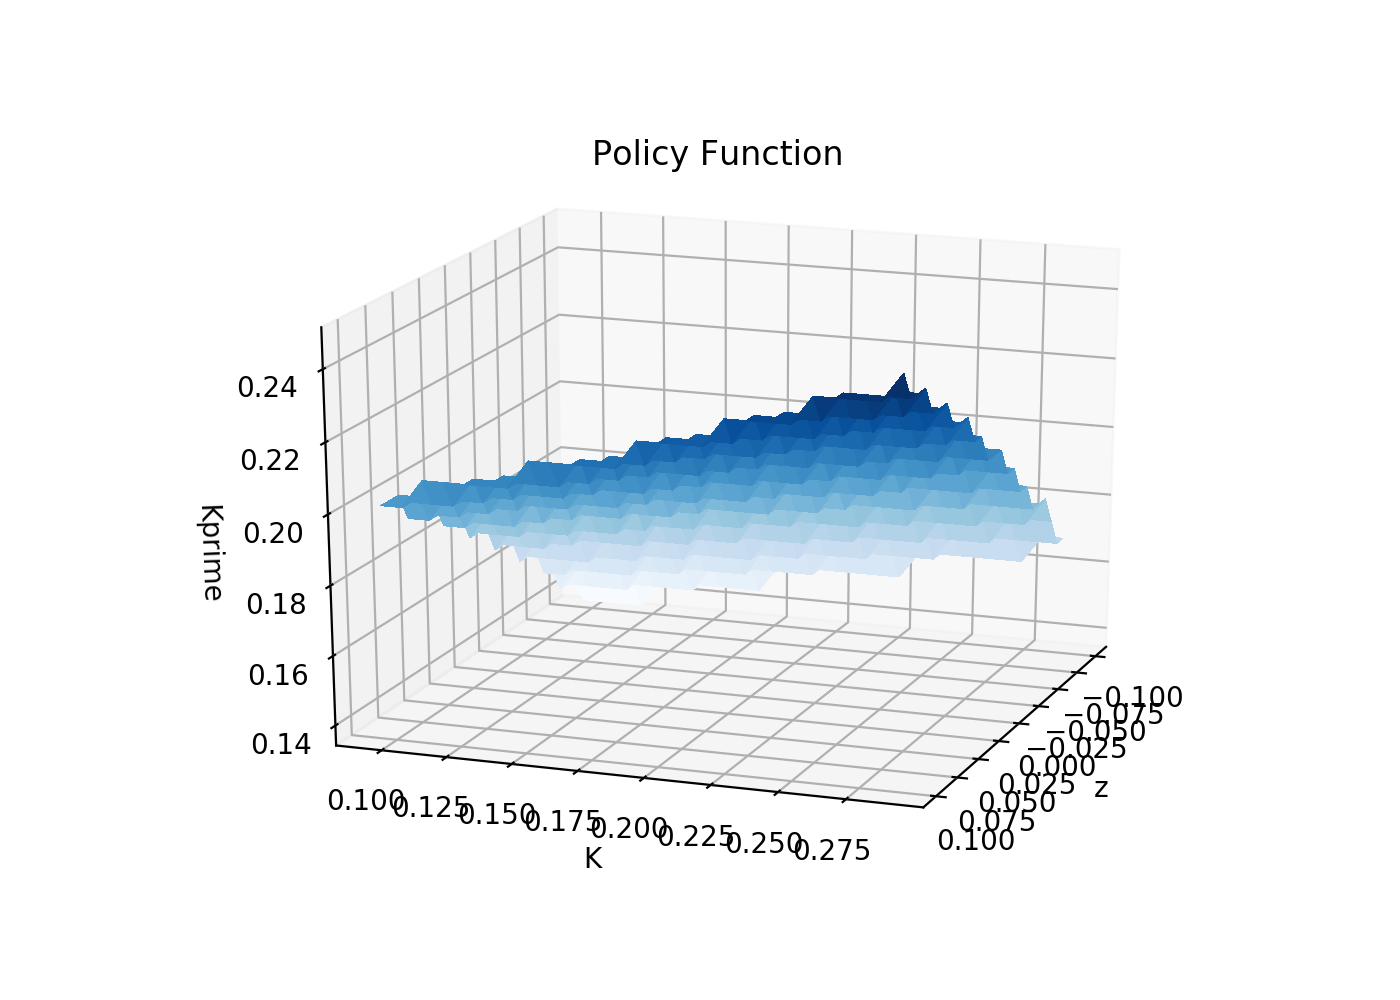

In [84]:
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

kprime = kvec[H]

zmat, kmat = np.meshgrid(z, kvec)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(zmat, kmat, kprime, rstride=1, cstride=1, cmap=cm.Blues,
                linewidth=0, antialiased=False)
ax.view_init(elev=20., azim=20.)  # to rotate plot for better view
ax.set_xlabel(r'z')
ax.set_ylabel(r'K')
ax.set_zlabel(r'Kprime')
plt.title("Policy Function")

<IPython.core.display.Javascript object>


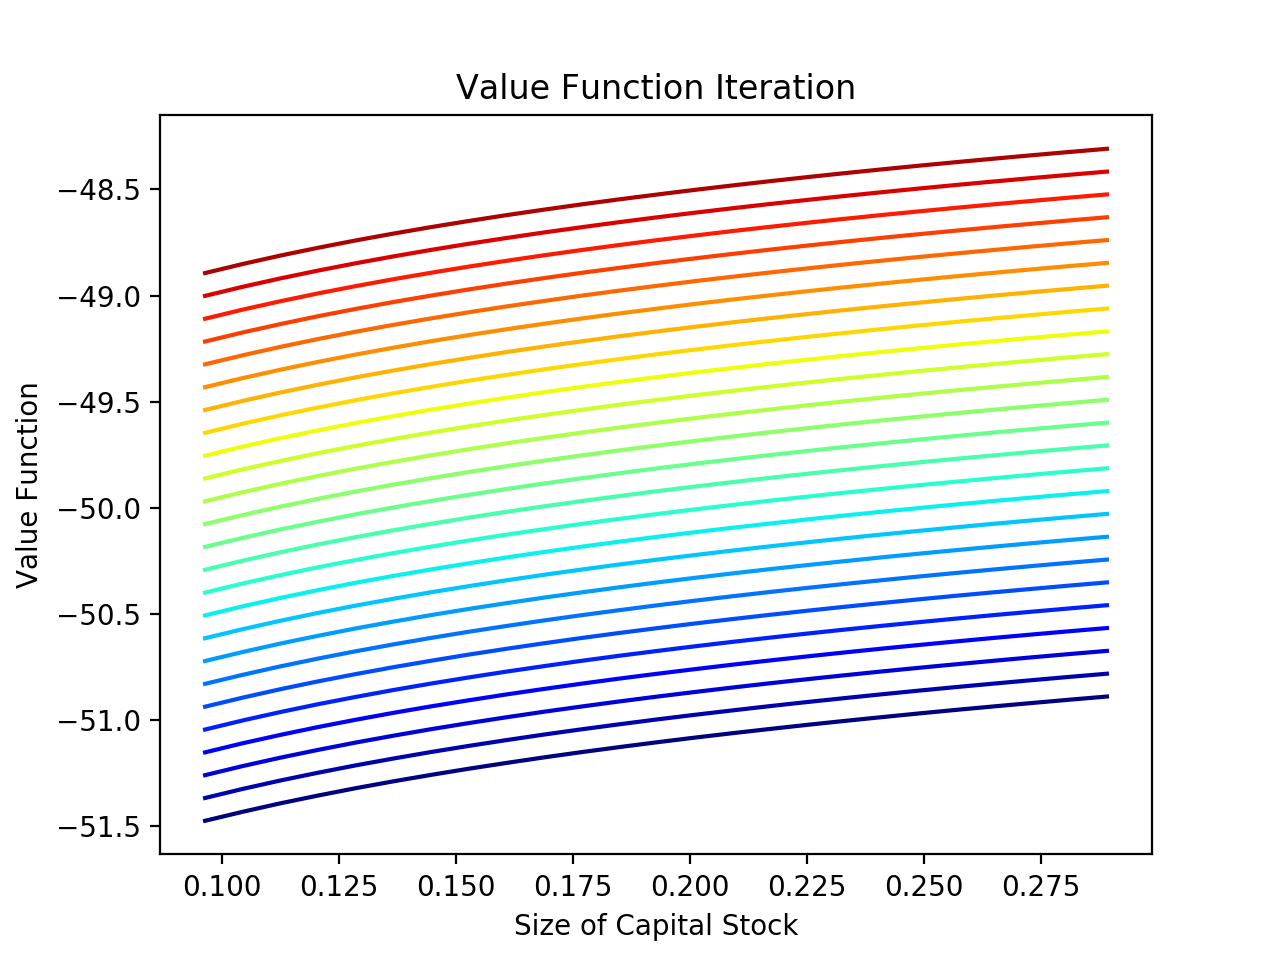

In [83]:
for i in range(size_z):
    plt.plot(kvec, VF[i], color=plt.cm.jet(i / size_z))
    plt.xlabel('Size of Capital Stock')
    plt.ylabel('Value Function')
    plt.title('Value Function Iteration')